## Bibliotecas e Pastas

In [4]:
import random
import itertools
from typing import List
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from feasible_instance_generator import InstanceGenerator
from geografics import generate_random_geografic_points
from grouping import GeoGrouper, EAVRPGroup
from utils import Passenger, Vehicle, RechargePoint, Depot
from encoder import Encoder

from graph import Graph

In [5]:
OUTDIR = Path("outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

## Parâmetros
Quantidade de 
- Passageiros
- Veículos
- Pontos de recargas
- Depósitos (ponto para saída e retorno de veículos)

In [6]:
seed = 42
p=2
shots=1000
steps=100
diameter = 0.004 # 1 => 100km 

In [7]:
# Quadrado equivalente a área da cidade de São Paulo
xlim = (-24.0, -23.4)
ylim = (-46.8, -46.3)

n_passengers = 6
n_vehicles = 4
n_recharge_points = 1
n_depots = 1

filename_hist = OUTDIR / "teste_histograma.png" # nome do arquivo do histograma
filename_graph = OUTDIR / f"teste_grafo_P{n_passengers}V{n_vehicles}R{n_recharge_points}D{n_depots}.png" # nome do arquivo do grafo

## Construção de Instâncias viáveis

In [8]:
vehicles, passengers, depots, recharge_points = InstanceGenerator(
        n_passengers=n_passengers,
        n_vehicles=n_vehicles,
        n_depots=n_depots,
        n_recharges=n_recharge_points,
    ).build()

## Agrupamento de Passageiros

In [9]:
grouper = GeoGrouper(delta=diameter)
groups = grouper.fit(passengers)

for g in groups:
    p_ids = [passenger.id for passenger in g.passengers]
    print(f"Grupo {g.id:02d} | {len(p_ids)} passageiros -> {p_ids}")

total_qubits = len(groups)  # variável por grupo (modelo futuro)
print(f"Total de grupos (≈ qubits na formulação): {total_qubits}")

Grupo 01 | 3 passageiros -> ['1', '2', '4']
Grupo 02 | 1 passageiros -> ['3']
Grupo 03 | 1 passageiros -> ['5']
Grupo 04 | 1 passageiros -> ['6']
Total de grupos (≈ qubits na formulação): 4


## Grafo do VRP

Grafo salvo em: outputs/teste_grafo_P6V4R1D1.png


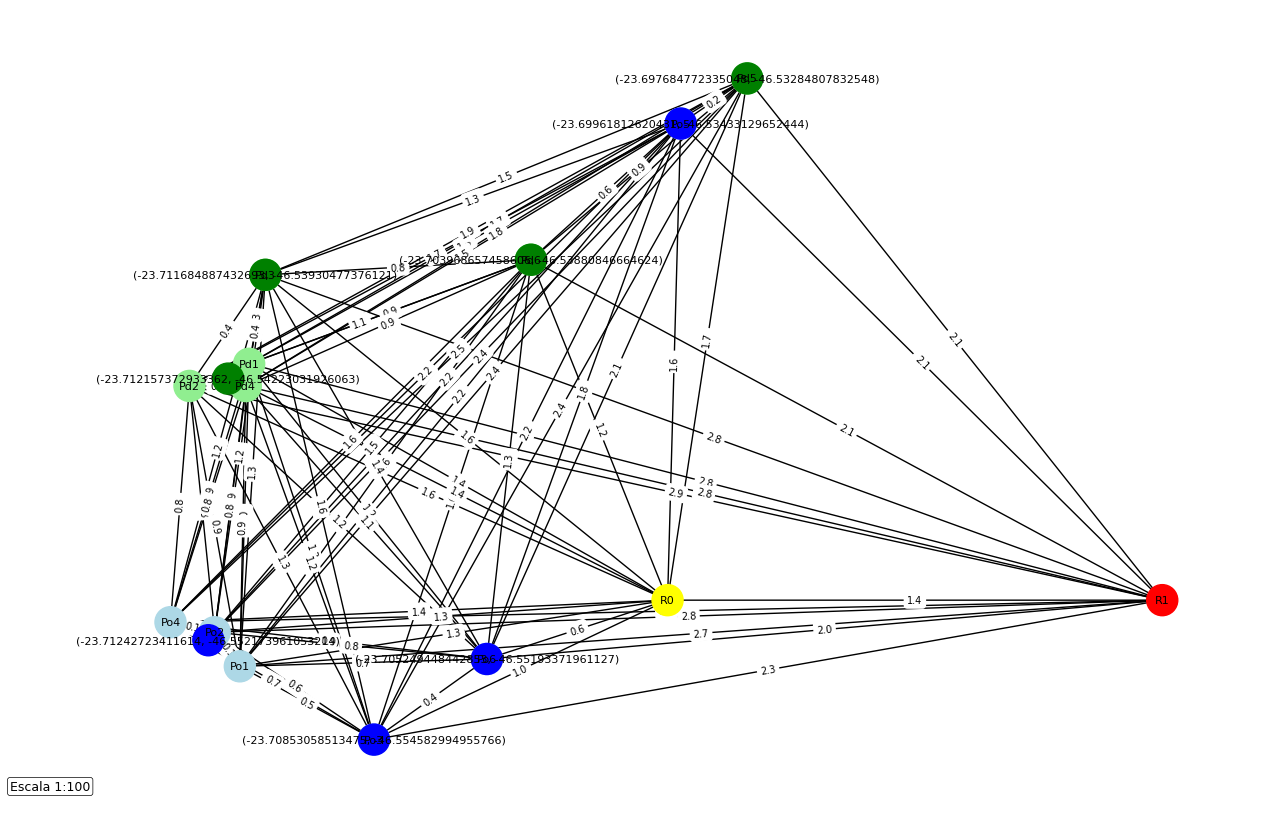

In [10]:
graph = Graph(passengers, groups, recharge_points, depots)
graph.save(filename_graph)

print(f"Grafo salvo em: {filename_graph}")

## Construção do QUBO

In [12]:
# QUBO para somente grupos sem compressão geográfica
encoder = Encoder(
    vehicles, 
    groups, 
    recharge_points,
    depot=depots
)


In [13]:
print(f"Quantidade de qubits com agrupamento: {encoder.num_qubits}")

Quantidade de qubits com agrupamento: 16


In [14]:
print("Matriz QUBO (valores arredondados a 2 casas decimais):")
encoder.print_matrix(precision=2)

Matriz QUBO (valores arredondados a 2 casas decimais):
[[0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.03 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.03 0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   

No contexto do `encoder` e do QUBO:

* O QUBO é definido como uma matriz $Q$ e uma constante $c$.
* A energia de um bitstring $x \in \{0,1\}^n$ é

  $$
  E(x) = x^T Q x + c.
  $$
* Esse $c$ é o **offset**.

Ele aparece porque, ao compilar expressões simbólicas (como em PyQUBO), termos quadráticos são expandidos em somas de termos lineares e constantes. Essas constantes independem das variáveis, mas fazem parte da energia total.

**Resumo prático:**

* `offset` é o **termo constante do Hamiltoniano/QUBO**, que não afeta qual bitstring é ótimo (porque é igual para todas as soluções).
* Mas ele é necessário quando você quer que a energia medida corresponda exatamente ao custo original.
* No solver clássico (`classical_solver.py`), você vê: se `encoder.cost(bits)` não existe, eles usam `energy - offset`. Isso remove esse deslocamento constante e retorna só o “custo limpo” da solução.

Quer que eu mostre como calcular explicitamente o **custo sem offset** para um bitstring dado?


In [15]:
print(f"Offset (c): {encoder.offset:.2f}")

Offset com compressão (constante): 0.00


## Otimização pelo algoritmo QAOA

In [16]:
# 3) QAOA 
solver = QAOASolver(encoder,
                    p=p,
                    shots=shots,
                    steps=steps,
                    dev="lightning.qubit", # "default.qubit"
                    seed=seed,
                    optimizer="cobyla",
                    maxiter=500,
                   )
# best_bits, best_cost = solver.solve()

results = solver.solve()
best_bits = results.best_bits
best_cost = results.best_cost


NameError: name 'QAOASolver' is not defined

In [13]:
# Estado inteiro x (LSB = qubit 0)
x_val = int("".join(map(str, best_bits[::-1])), 2)
print(f"Bitstring: {best_bits} => Melhor estado: |{x_val}⟩  ==> custo {best_cost:.2f}\n")

Bitstring: [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] => Melhor estado: |1042⟩  ==> custo 1.13



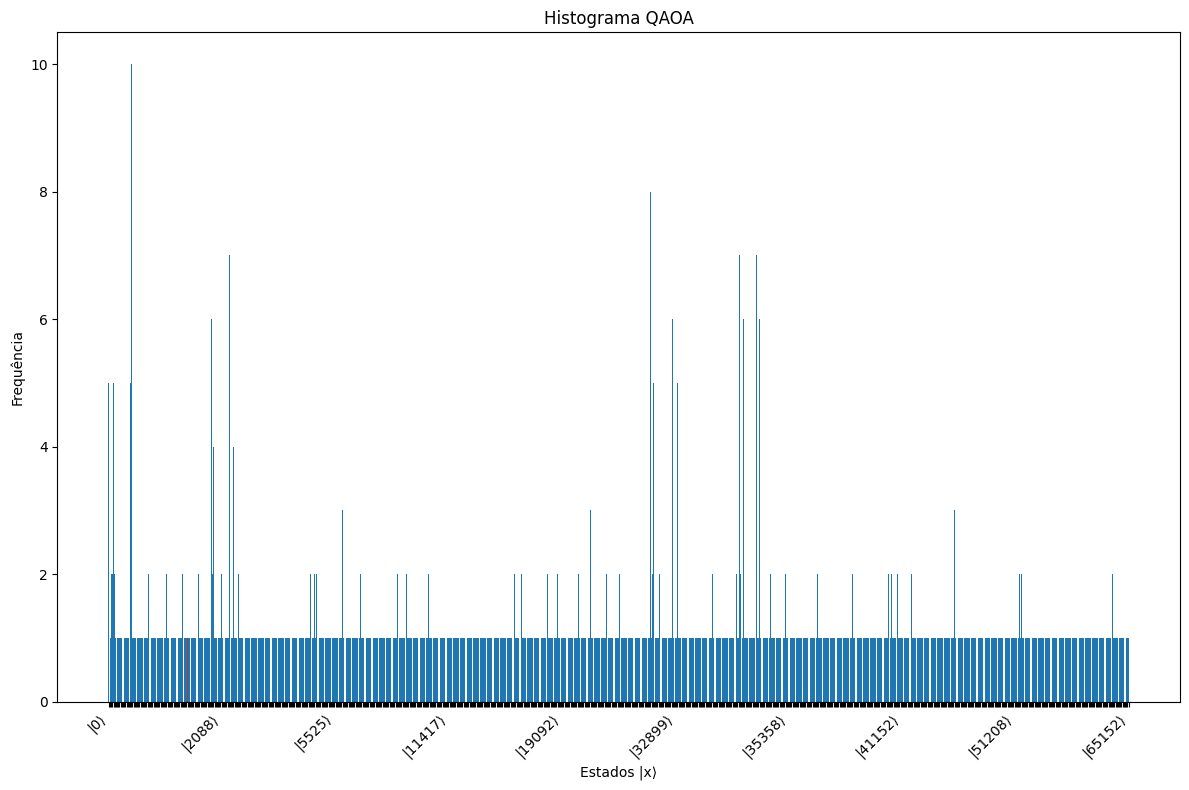

Histograma salvo em: outputs/teste_histograma.png


In [14]:
# 4) Histograma
solver.plot_histogram(filename_hist)
print(f"Histograma salvo em: {filename_hist}")

# Solução por método Clássico

Busca de rotas resolvidas para pequenas instâncias de EA-VRP *sem* hardware quântico. A classe abaixo reutiliza o QUBO que o `QUBOEncoder` já constrói e o alimenta em um solucionador exato **clássico** (`dimod.ExactSolver`). Como a busca é exaustiva, ela é prática apenas para exemplos toy model (máximo de 25 a 30 variáveis binárias), mas é totalmente determinística e produz o ótimo global.

In [15]:
from classical_solver import ClassicalVRPSolver

In [16]:
solver = ClassicalVRPSolver(encoder)

In [17]:
solver.solve()                 # leva milissegundos nesta instância
best = solver.best()
best

{'bits': '0100000000101000',
 'energy': 1.1285406437629162,
 'feasible': False,
 'cost': nan,
 'routes': {0: {'groups': [1], 'stations': []},
  1: {'groups': [], 'stations': []},
  2: {'groups': [2], 'stations': []},
  3: {'groups': [0], 'stations': []}}}